# Data Scientist Professional Practical Exam Submission



## 1. Data Validation
This dataset has 947 entries and 8 columns, there are some missing values in some of the columns. 

- recipe: 947 unique identifier as described, no cleaning is needed.

**For the category columns:**
- category: 11 categories, with no missing values. The additional category compared to the description is 'Chicken Breast', this has been recategorical as 'Chicken'
- servings: no missing values but 3 receipes has non-numerical servings as '4 as a snack'and '6 as a snack'. These 3 recipes are already categorized as Lunch/Snack. Remove characters and change data type into integer. 
- high_traffic: 373 missing values, since only marked as high if traffic to the site was high. Mapped high to 1 and rest to 0. 

**For the numeric columns:**
- There are 4 numeric columns : calories, carbohydrate, sugar, protein
- There are 52 recipes with missing values in all of these four numeric columns. Filled each column's missed values with the mean grouped by category and servings.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix


plt.style.use('ggplot')

In [3]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [5]:
len(df['recipe'].unique())

947

In [6]:
# validating category
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [7]:
# replace chicken breast as chicken 
df['category']=df['category'].str.replace('Chicken Breast','Chicken')

df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

In [8]:
# validating serving 
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [9]:
rows_with_snack_in_servings = df[(df['servings']=='4 as a snack') | (df['servings']=='6 as a snack')]
rows_with_snack_in_servings

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


'4 as a snack', '6 as a snack' occurs in only 3 occasions, and already in the category of Snacks.
Therefore remove the characters

In [10]:
# remove characters other than digits
df['servings']=df['servings'].str.replace(r'\D+', '')
df['servings']=df['servings'].astype('int32')
df['servings'].unique()

array([6, 4, 1, 2], dtype=int32)

In [11]:
# validing high_traffic 
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [12]:

df['high_traffic'] = df['high_traffic'].fillna('Low')
mapping = {'High':1, 'Low':0}
df['high_traffic'] = df['high_traffic'].map(mapping).astype('category')
df['high_traffic'].unique()

[1, 0]
Categories (2, int64): [0, 1]

In [13]:
#validate values in numeric variables
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,895.000000,895.000000,895.000000,895.000000,947.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296,3.477297
std,273.519652,453.020997,43.949032,14.679176,36.369739,1.732741
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,710.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


In [14]:
# inspect the recipe with missing values
rows_with_missing_df = df[df.isna().any(axis=1)]
rows_with_missing_df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,1
23,24,NaN,NaN,NaN,NaN,Meat,2,0
48,49,NaN,NaN,NaN,NaN,Chicken,4,0
82,83,NaN,NaN,NaN,NaN,Meat,4,1
89,90,NaN,NaN,NaN,NaN,Pork,6,1


In [15]:
# check number of recipe with missing values in each category
rows_with_missing_df.groupby(['category'])['recipe'].count()

category
Chicken           9
Dessert           6
Lunch/Snacks      7
Meat              5
One Dish Meal     4
Pork             11
Potato            5
Vegetable         5
Name: recipe, dtype: int64

In [16]:
# check number of recipe with missing values for each serving
rows_with_missing_df.groupby(['servings'])['recipe'].count()

servings
1     6
2     9
4    24
6    13
Name: recipe, dtype: int64

In [17]:
# extracting the 4 numeric columns with missing values
cols_with_missing = df.columns[df.isna().any()]
cols_with_missing

Index(['calories', 'carbohydrate', 'sugar', 'protein'], dtype='object')

In [18]:
# fill missed values with the mean grouped by category and servings.
for col_name in cols_with_missing.values:
     df[col_name] = df[col_name].fillna(df.groupby(["category","servings"])[col_name].transform('mean'))


In [19]:
# inspecting the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      947 non-null    float64 
 2   carbohydrate  947 non-null    float64 
 3   sugar         947 non-null    float64 
 4   protein       947 non-null    float64 
 5   category      947 non-null    object  
 6   servings      947 non-null    int32   
 7   high_traffic  947 non-null    category
dtypes: category(1), float64(4), int32(1), int64(1), object(1)
memory usage: 49.3+ KB


In [20]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,439.825661,35.121916,9.064490,24.577414,3.477297
std,273.519652,442.246009,42.905677,14.447594,35.764050,1.732741
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000,2.000000
50%,474.000000,306.900000,22.330000,4.925750,11.240000,4.000000
75%,710.500000,594.475000,44.740000,9.565000,32.360000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


## 2. Exploratory Analysis
I have investigated the target variable and features of the recipe and the relationship between target variable and features. Only the **category** features seems to have relationship with high traffic. 

The Numerical Variables - calories, carbohydrate, sugar, protein are all postively skewed.

In [21]:
# define some functions to use for categorical variable graphs plotting
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["High", "Low"], loc=legend_)
    # Labels
    plt.ylabel("Recipe Percentages (%)")
    plt.show()

    
def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )
        

### Target Variable - high_traffic
60.6% of recipes have high traffic level.

In [22]:
high_traffic = df[['recipe', 'high_traffic']]
high_traffic.columns = [' ', 'high_traffic']
traffic_total = high_traffic.groupby(high_traffic['high_traffic']).count()
traffic_percentage = traffic_total / traffic_total.sum() * 100

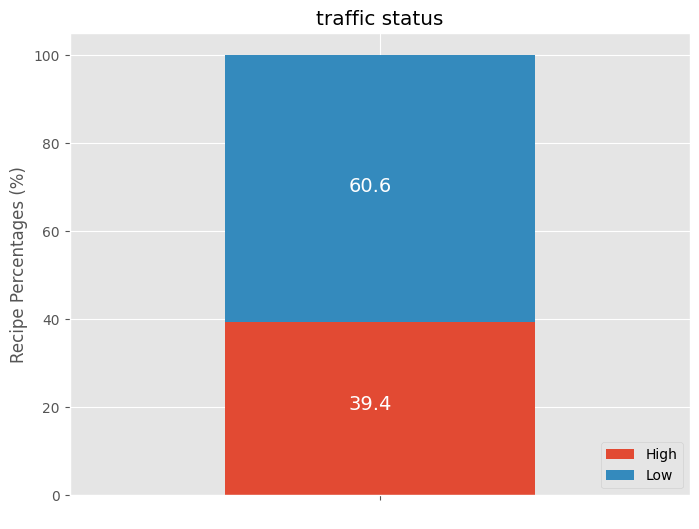

In [23]:
plot_stacked_bars(traffic_percentage.transpose(), "traffic status", (8, 6), legend_="lower right")

### Cateorical Variables - category, servings
From the bar chart below, the most common recipe is chicken. Also, the most common serving size in is 4.

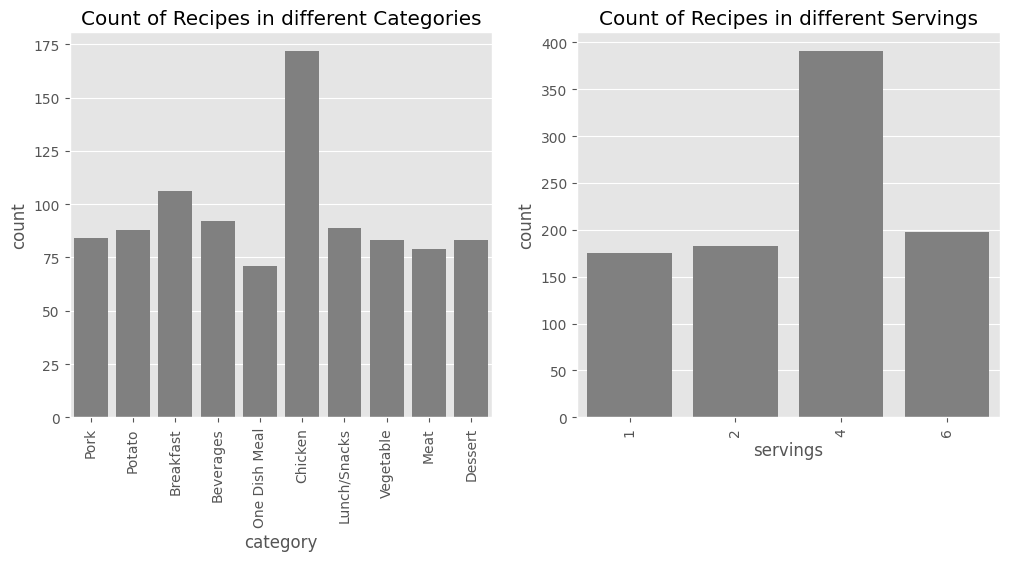

In [24]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=df['category'],color='gray',ax=axes[0]).set(title='Count of Recipes in different Categories')
sns.countplot(x=df['servings'],color='gray',ax=axes[1]).set(title='Count of Recipes in different Servings')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

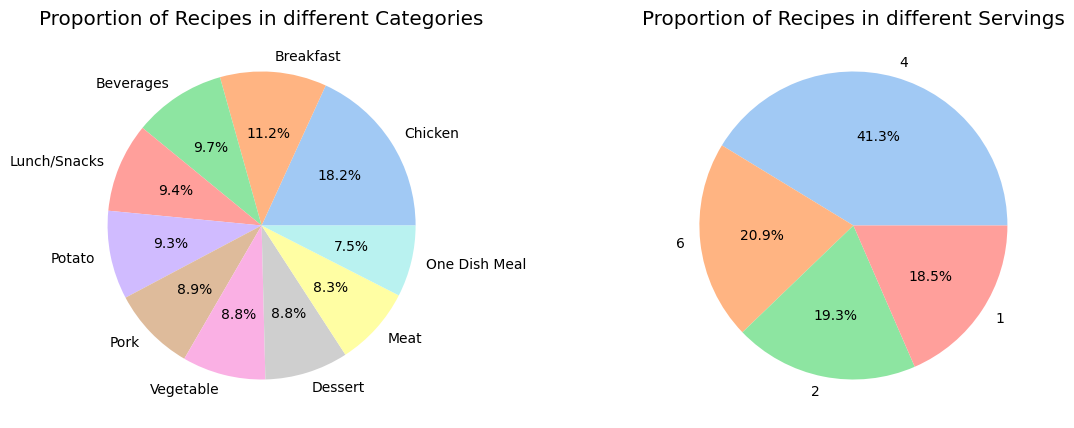

In [25]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), ax=axes[0]).set(title='Proportion of Recipes in different Categories', ylabel='')
df['servings'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), ax=axes[1]).set(title='Proportion of Recipes in different Servings', ylabel='')
plt.ylabel('')
plt.show()

### Relationship between traffic levels to cateorical variables

#### Category
From first bar chart below, we can see that recipes in Beverages category is most popular, 94.6% of recipes in this category will have high traffic while Vegetable category is least favoured, only Category feature could be an important feature for our model.

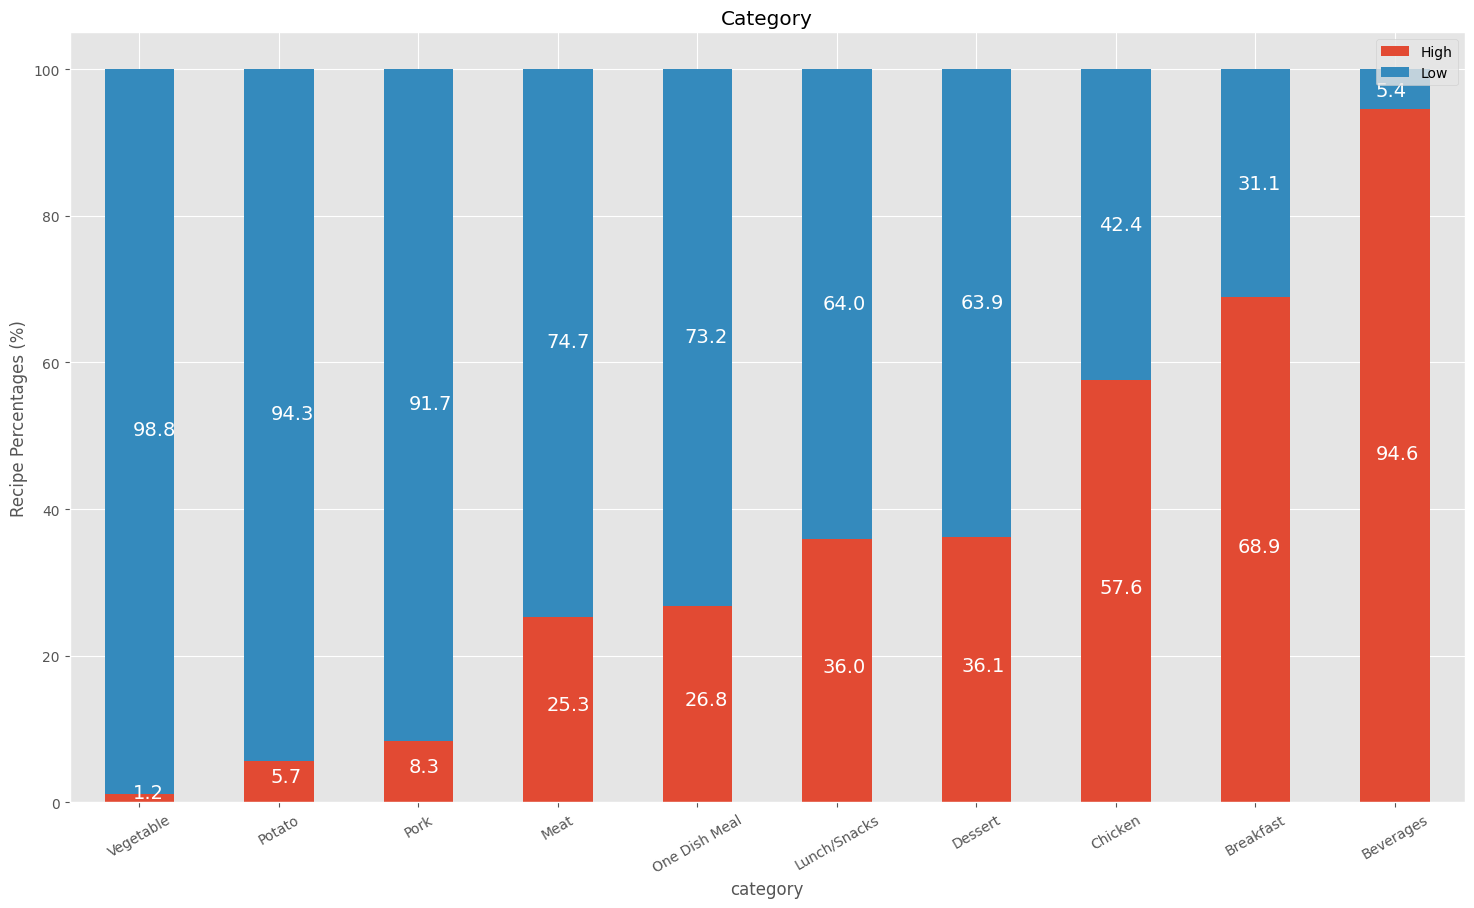

In [26]:
category_df = df[['recipe', 'category', 'high_traffic']]
category_df = category_df.groupby([category_df['category'], category_df['high_traffic']])['recipe'].count().unstack(level=1)
category_traffic = (category_df.div(category_df.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)
plot_stacked_bars(category_traffic , 'Category', rot_=30)

#### Servings
From second bar char below, we can see that the traffic level is indifferent for different servings.

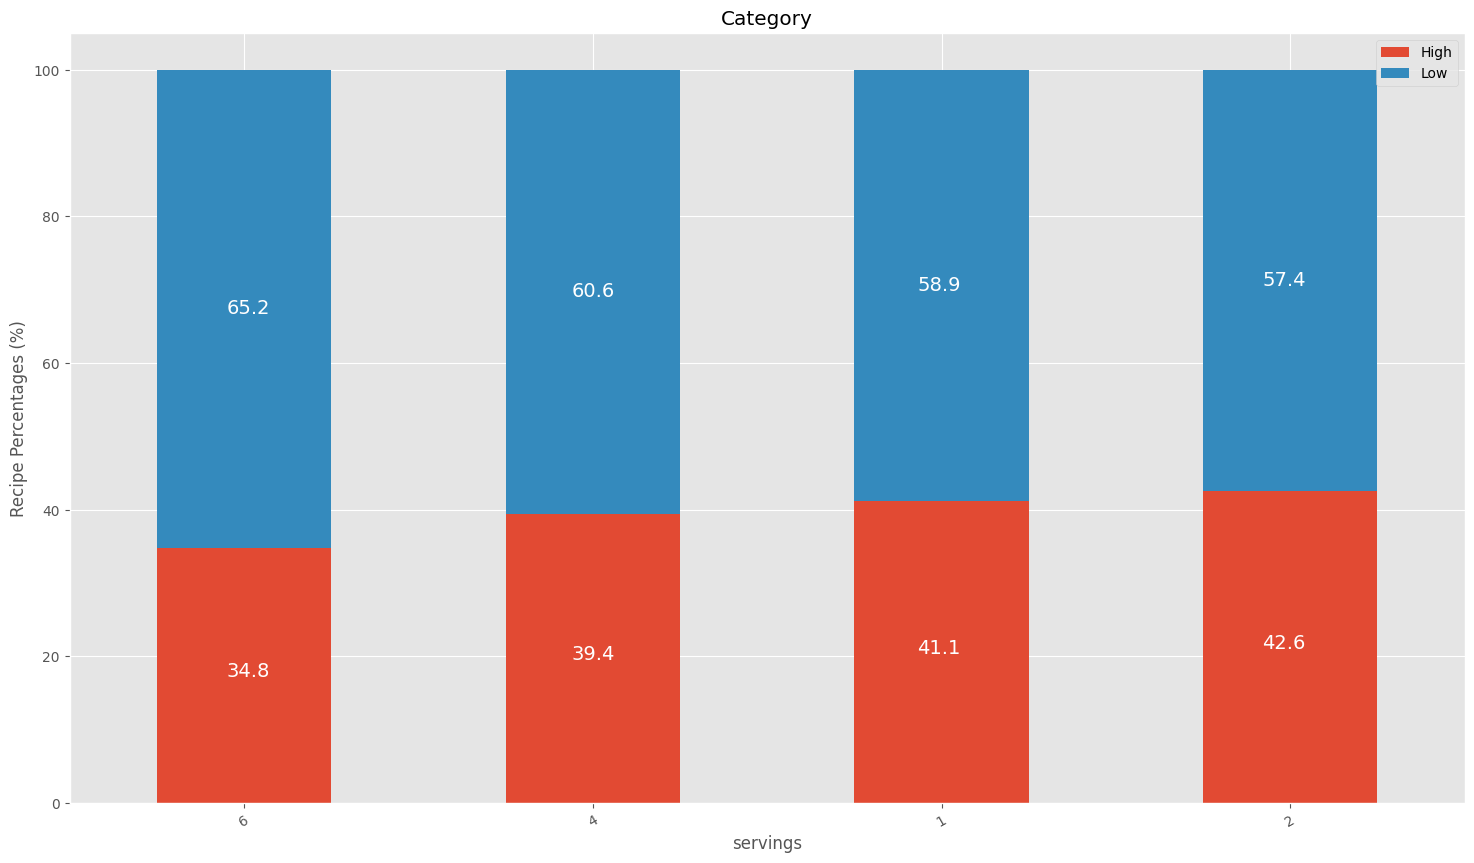

In [27]:
serving_df = df[['recipe', 'servings', 'high_traffic']]
serving_df = serving_df.groupby([serving_df['servings'], serving_df['high_traffic']])['recipe'].count().unstack(level=1)
serving_traffic = (serving_df.div(serving_df.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)
plot_stacked_bars(serving_traffic , 'Category', rot_=30)

### Numerical Variables - calories, carbohydrate, sugar, protein
Look at characteristics of different numerical variables. The distribution plot for each numerical variable shows that all of these variables are postively skewed. After applying log transforamtion of the price variable, the distribution on the right below is closer to the normal distribution.

#### Distribution of Calories

[Text(0.5, 1.0, 'The Distribution of Calories (Log Scale)')]

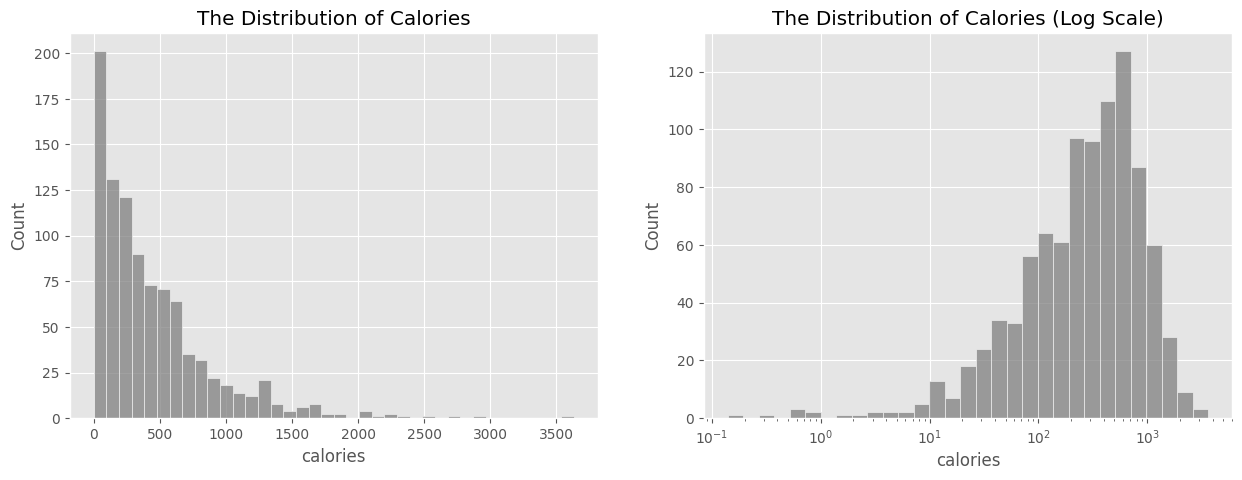

In [28]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df['calories'],color='gray', ax=axes[0]).set(title='The Distribution of Calories')
sns.histplot(df['calories'],log_scale=True,color='gray', ax=axes[1]).set(title='The Distribution of Calories (Log Scale)')

#### Distribution of Carbohydrate

[Text(0.5, 1.0, 'The Distribution of Carbohydrate (Log Scale)')]

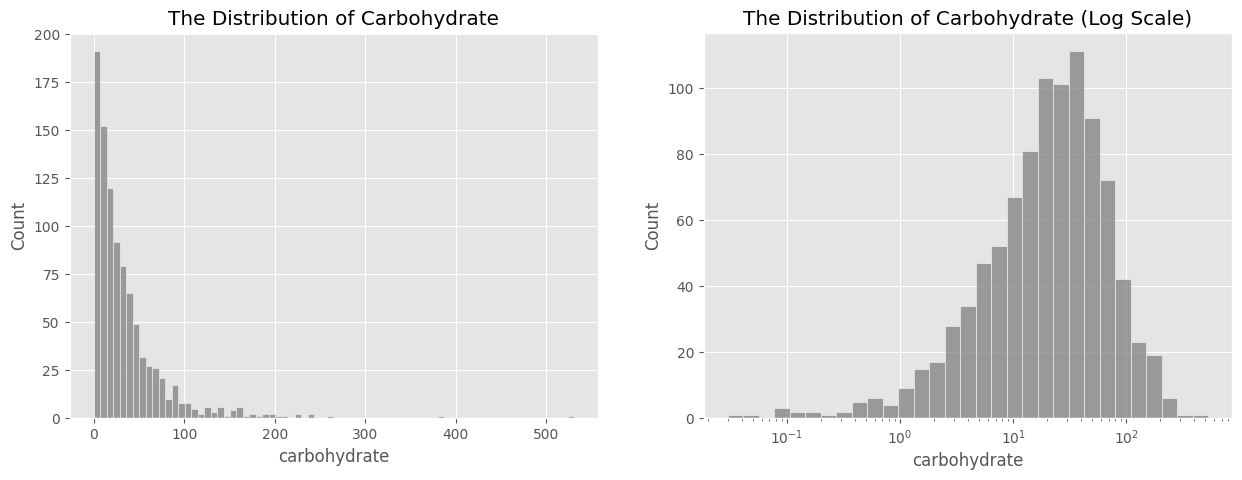

In [29]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df['carbohydrate'],color='gray', ax=axes[0]).set(title='The Distribution of Carbohydrate')
sns.histplot(df['carbohydrate'],log_scale=True,color='gray', ax=axes[1]).set(title='The Distribution of Carbohydrate (Log Scale)')

#### Distribution of Sugar

[Text(0.5, 1.0, 'The Distribution of Sugar (Log Scale)')]

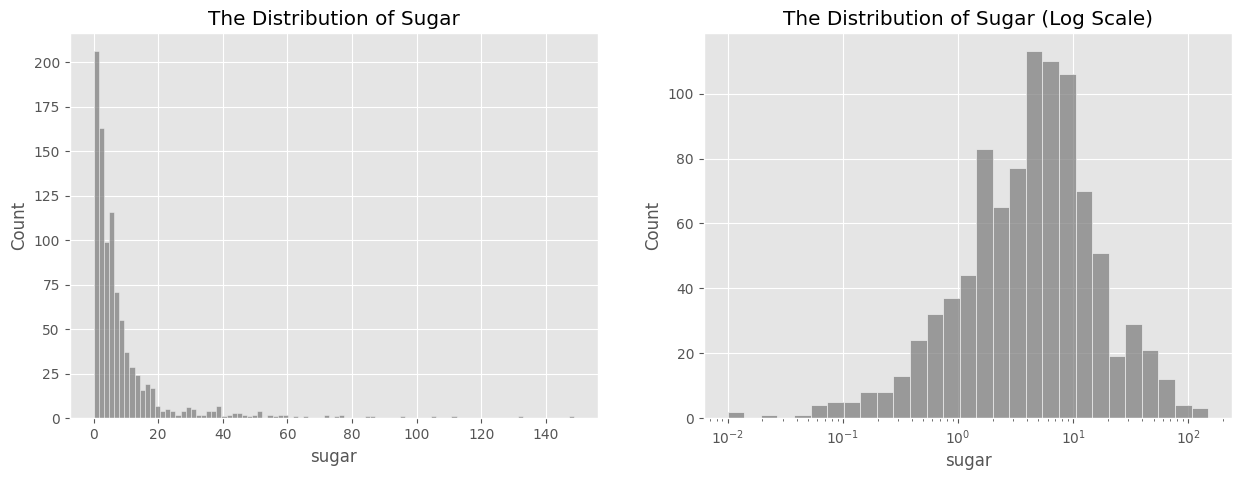

In [30]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df['sugar'],color='gray', ax=axes[0]).set(title='The Distribution of Sugar')
sns.histplot(df['sugar'],log_scale=True,color='gray', ax=axes[1]).set(title='The Distribution of Sugar (Log Scale)')

#### Distribution of Protein

[Text(0.5, 1.0, 'The Distribution of Protein (Log Scale)')]

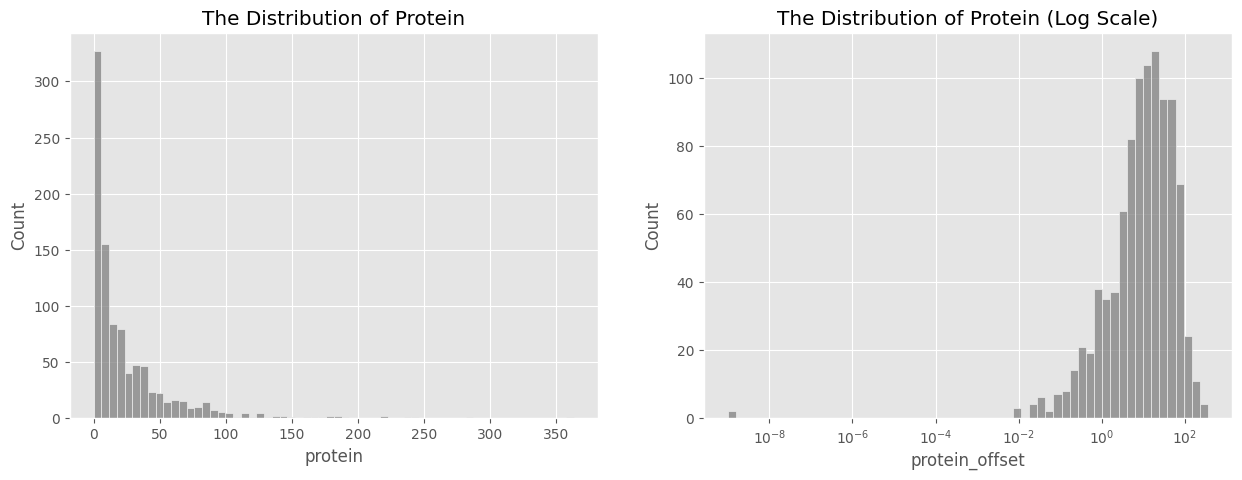

In [31]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.histplot(df['protein'],color='gray', ax=axes[0]).set(title='The Distribution of Protein')
# protein has value of zero, Add a small offset (e.g., 1e-9) to the 'protein' column to avoid taking the log of zero
df['protein_offset'] = df['protein'] + 1e-9
sns.histplot(df['protein_offset'],log_scale=True,color='gray', ax=axes[1]).set(title='The Distribution of Protein (Log Scale)')

#### Boxplot of numeric variables
Boxplots have suggested that there are some outliner datapoint for the numerical variables.

[Text(0.5, 1.0, 'The Boxplot of Protein')]

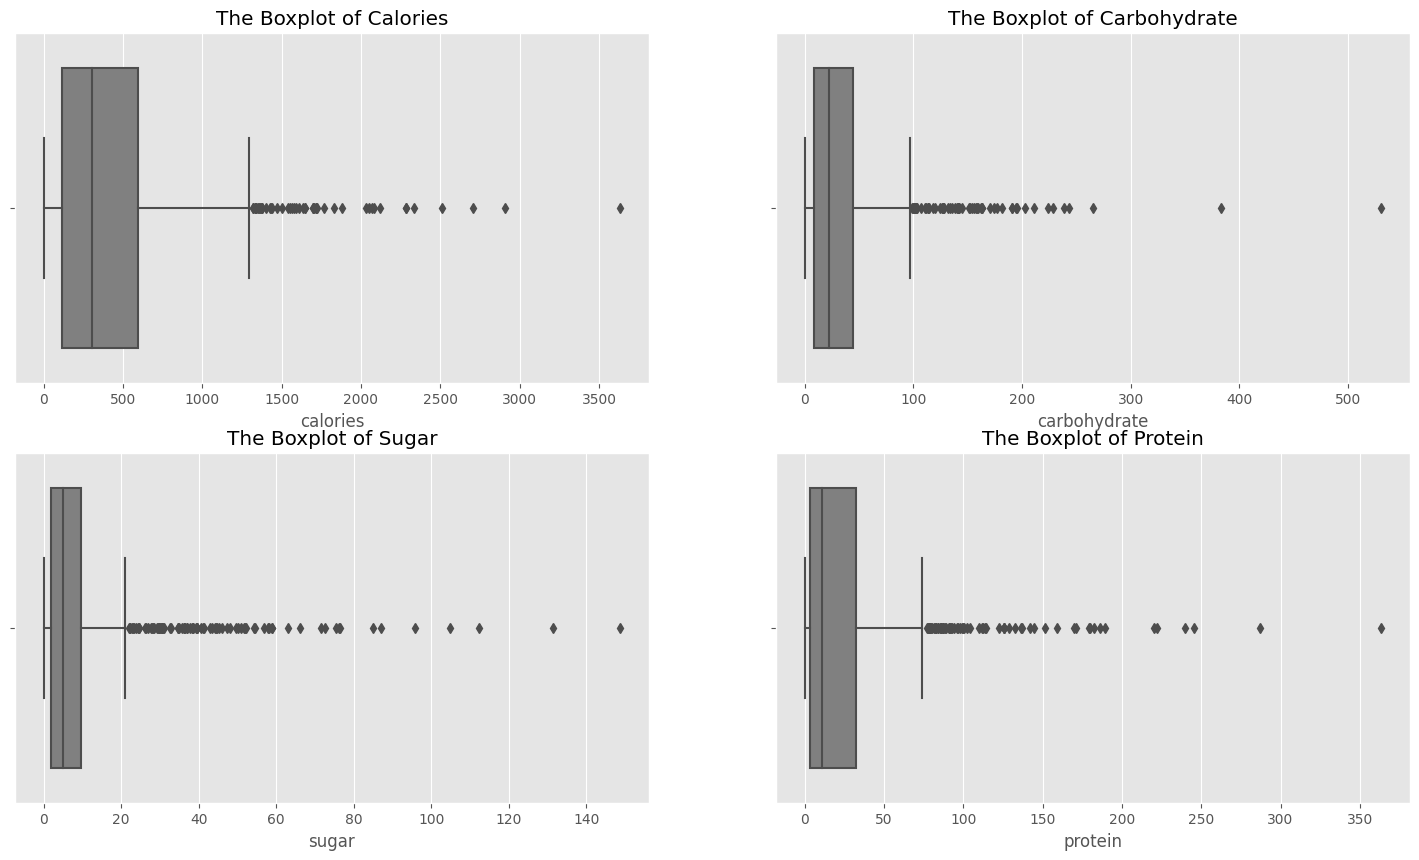

In [32]:
fig, axes = plt.subplots(2,2,figsize=(18,10))
sns.boxplot(x=df['calories'],color='gray', ax=axes[0,0]).set(title='The Boxplot of Calories')
sns.boxplot(x=df['carbohydrate'],color='gray', ax=axes[0,1]).set(title='The Boxplot of Carbohydrate')
sns.boxplot(x=df['sugar'],color='gray', ax=axes[1,0]).set(title='The Boxplot of Sugar')
sns.boxplot(x=df['protein'],color='gray', ax=axes[1,1]).set(title='The Boxplot of Protein')

### Relationship between traffic levels to numerical variables

#### Heatmap
From heatmap below, there are no clear linear relationships between the numerical variables and the high traffic level.

[Text(0.5, 1.0, 'The Correlation Heatmap between Numeric Variables and traffic levels')]

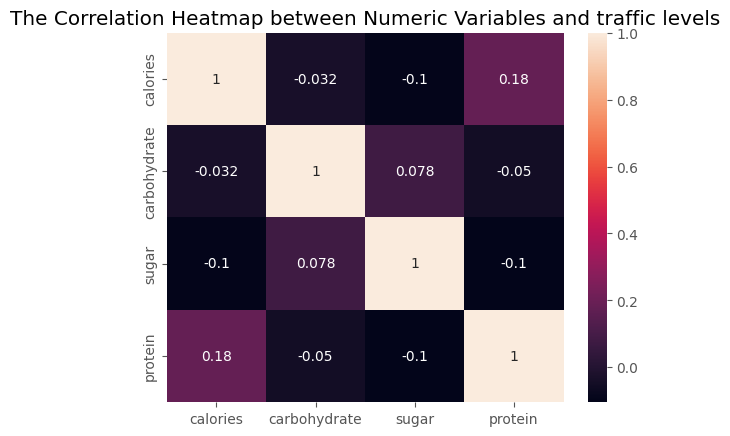

In [33]:
numeric = df[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']]
sns.heatmap(numeric.corr(),annot=True).set(title='The Correlation Heatmap between Numeric Variables and traffic levels')

#### Violin Plots

There aren't any visible difference of summary statistics for these numerical variables across the high and low traffic.

In [34]:
columns = [('calories', 'high_traffic', 'The Relationship Between Traffic levels and Calories'),
           ('carbohydrate', 'high_traffic', 'The Relationship Between Traffic levels and Carbohydrate'),
           ('sugar', 'high_traffic', 'The Relationship Between Traffic levels and Sugar'),
           ('protein', 'high_traffic', 'The Relationship Between Traffic levels and Protein')]

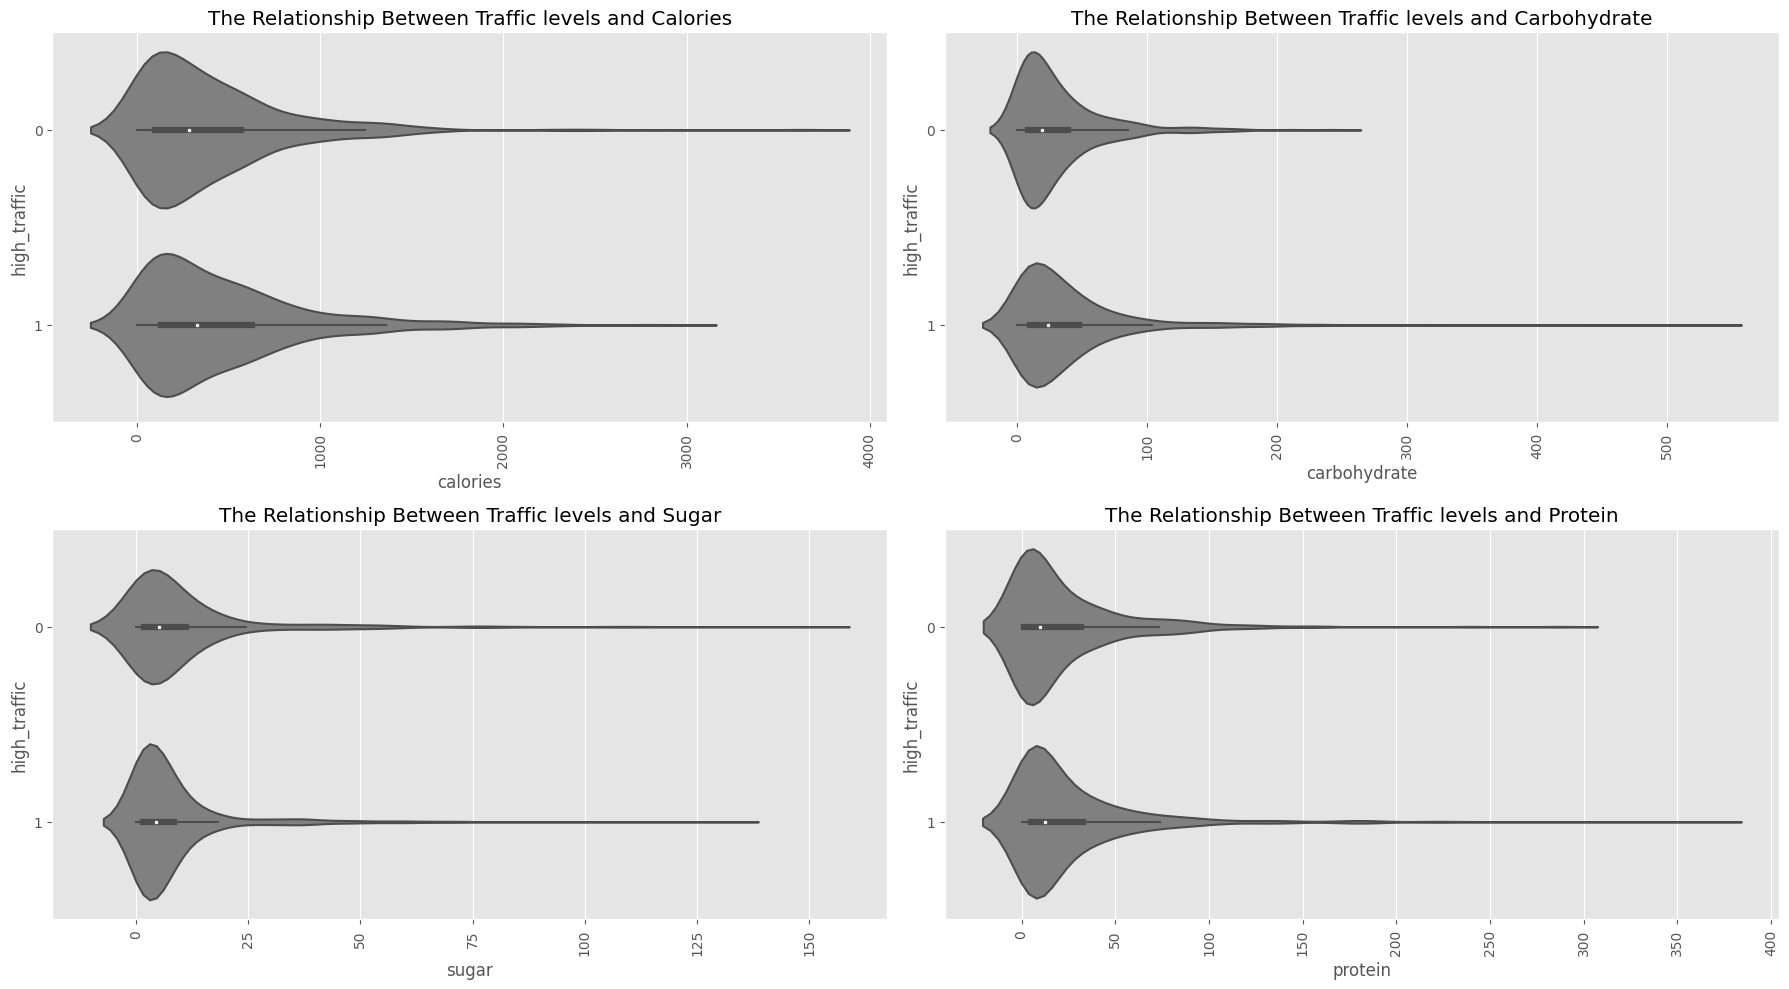

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for i, (x_col, y_col, title) in enumerate(columns):
    sns.violinplot(data=df, x=x_col, y=y_col, color='gray', ax=axes[i // 2, i % 2]).set(title=title)
    plt.sca(axes[i // 2, i % 2])
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#### Boxplot

Box plots again shows that there aren't any visible difference of summary statistics for these numerical variables across the high and low traffic.

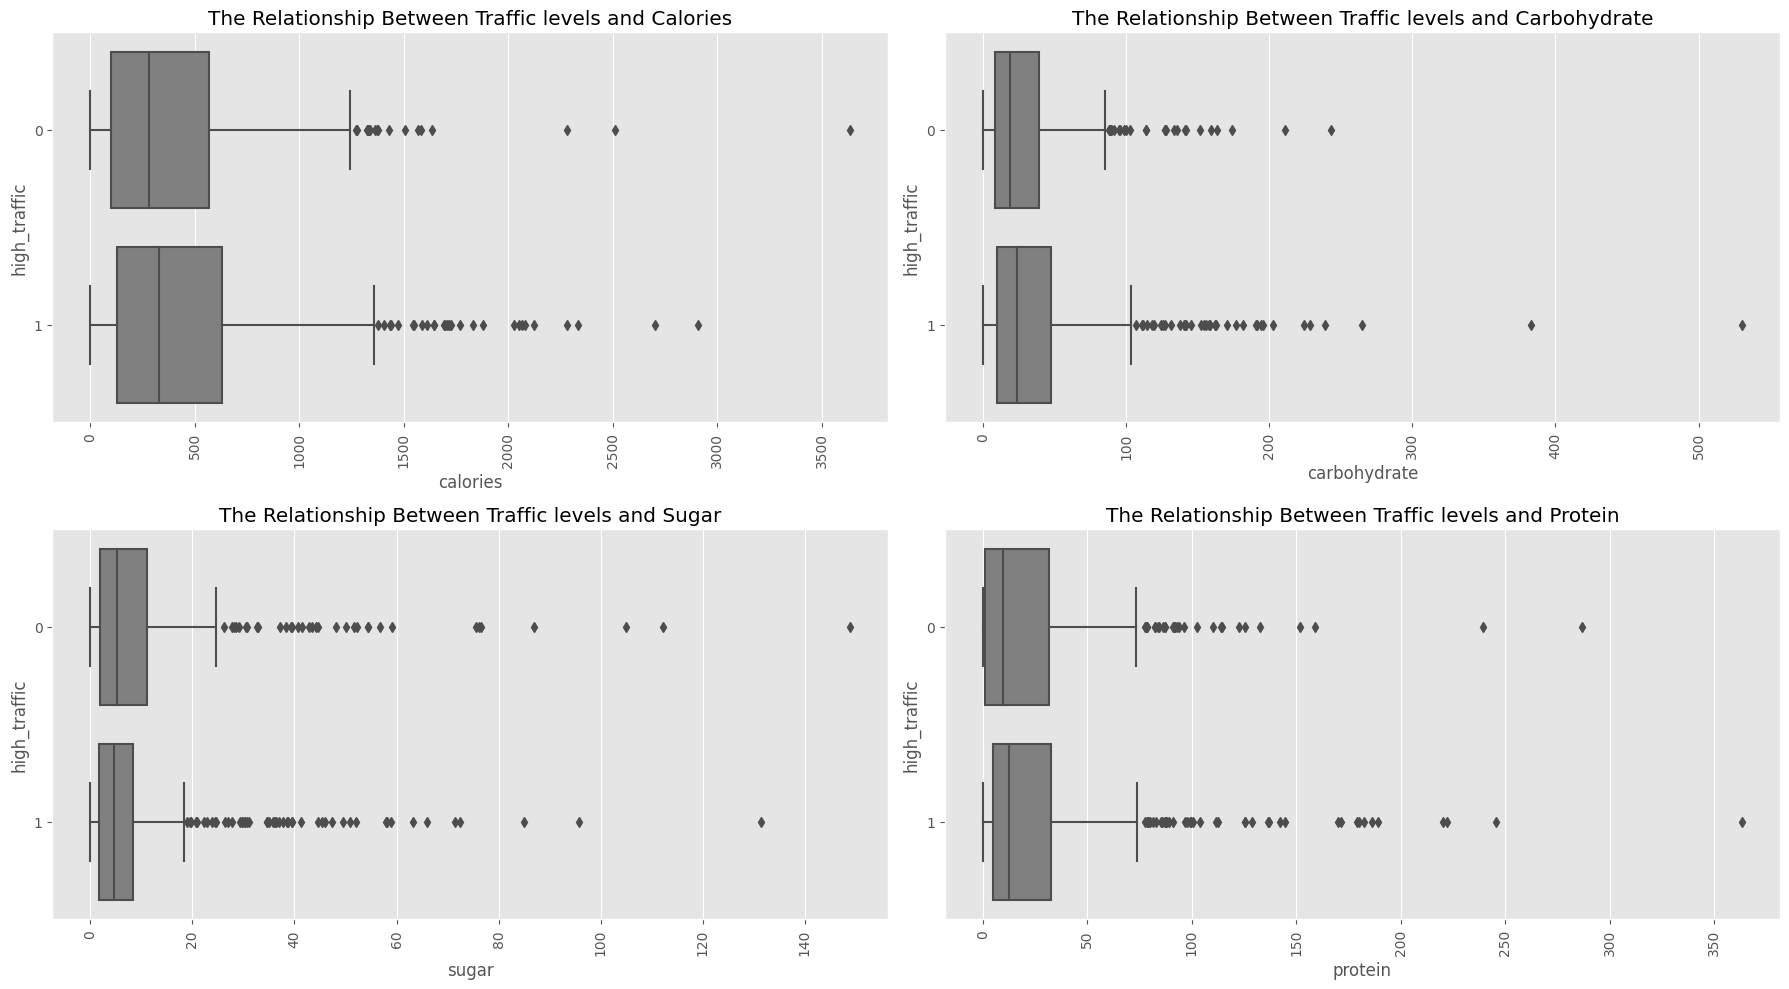

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for i, (x_col, y_col, title) in enumerate(columns):
    sns.boxplot(data=df, x=x_col, y=y_col, color='gray', ax=axes[i // 2, i % 2]).set(title=title)
    plt.sca(axes[i // 2, i % 2])
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## 3. Model Development
Predicting the traffic level is a **binary classification** problem in machine learning. 

A **Logistic Regression model** could be a good choice to start as baseline model for a binary classfication problems and the comparison model I am going to use is **Random Forest Classifier**. By comparing the performance of more complex models like Random Forest, we can evaluate whether the additional complexity of the ensemble model provides a significant improvement in accuracy and generalization.


### Prepare Data for Modelling
high_traffic is the target variables, with the rests as features.  

To prepare for the modelling, followings steps are adopted:

- Normalize the numeric features
- Split the data into a training set and a test set

In [37]:
labelencoder = LabelEncoder()
df['category'] = labelencoder.fit_transform(df['category'])

In [38]:
labels_dict = dict(zip(labelencoder.classes_, range(len(labelencoder.classes_))))
labels_dict

{'Beverages': 0,
 'Breakfast': 1,
 'Chicken': 2,
 'Dessert': 3,
 'Lunch/Snacks': 4,
 'Meat': 5,
 'One Dish Meal': 6,
 'Pork': 7,
 'Potato': 8,
 'Vegetable': 9}

In [39]:
feature_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']
X = df[feature_cols] # Features
y = df['high_traffic'] # Target variable
print(X.shape)
print(y.shape)

(947, 6)
(947,)


In [40]:
# define the scaler 
scaler = StandardScaler()
# fit and transform the train set
X_scaled = scaler.fit_transform(X)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

### Logistic Regression Model

#### Best parameters for Logistic Regression Model

In [46]:
logreg = LogisticRegression()

params_logreg = {"C": np.logspace(-3, 3, 10), 
             "penalty": ["l1", "l2", "elasticnet", None]
             }
grid_logreg = GridSearchCV(estimator=logreg, param_grid= params_logreg, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='accuracy', verbose=1)

In [44]:
logreg_best_model = grid_logreg.best_estimator_
print(f'Best model:{logreg_best_model}')
print(f'Best score:{grid_logreg.best_score_}')

Best model:LogisticRegression(C=0.1)
Best score:0.7643826322930801


#### Feature Importance 

In [58]:
logreg_feature_importances = pd.DataFrame({
    'features': feature_cols,
    'importance': logreg_best_model.coef_[0]
}).sort_values(by='importance', ascending=True).reset_index()

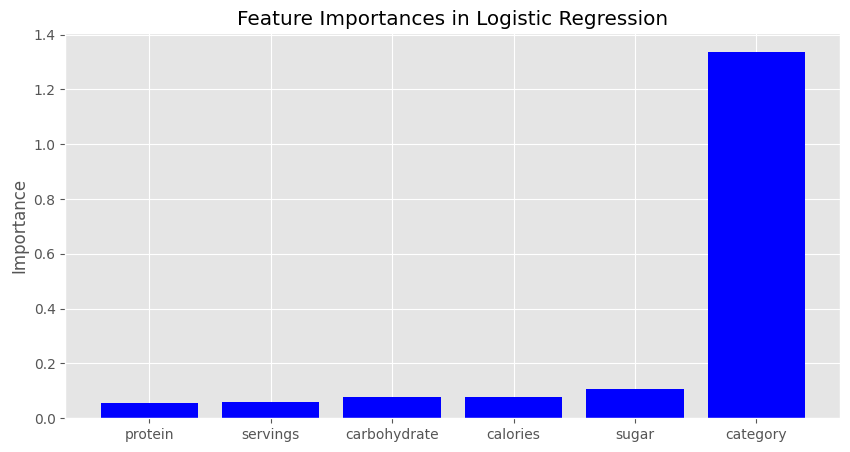

In [64]:
plt.figure(figsize=(10,5))
plt.title('Feature Importances in Logistic Regression')
plt.bar(range(len(logreg_feature_importances)), logreg_feature_importances['importance'], color='b', align='center')
plt.xticks(range(len(logreg_feature_importances)), logreg_feature_importances['features'])
plt.ylabel('Importance')
plt.show()


### Random Forest Classifier Model

#### Best parameters for Random Forest Model

In [149]:
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators': [300, 400, 500, 600,],
             'max_depth': [1, 3, 5],
             'min_samples_leaf': [0.0002, 0.0004, 0.0006],
             'max_features': [0.05, 0.1, 0.2]
             }
grid_rf = GridSearchCV(estimator=rf, param_grid= params_rf, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5],
                         'max_features': [0.05, 0.1, 0.2],
                         'min_samples_leaf': [0.0002, 0.0004, 0.0006],
                         'n_estimators': [300, 400, 500, 600]},
             scoring='accuracy', verbose=1)

In [150]:
rf_best_model = grid_rf.best_estimator_
print(f'Best model:{rf_best_model}')
print(f'Best score:{grid_rf.best_score_}')

Best model:RandomForestClassifier(max_depth=5, max_features=0.05, min_samples_leaf=0.0002,
                       n_estimators=300, random_state=42)
Best score:0.7402080506558119


#### Feature Importance

In [151]:
rf_feature_importances = pd.DataFrame({
    'features': feature_cols,
    'importance': rf_best_model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

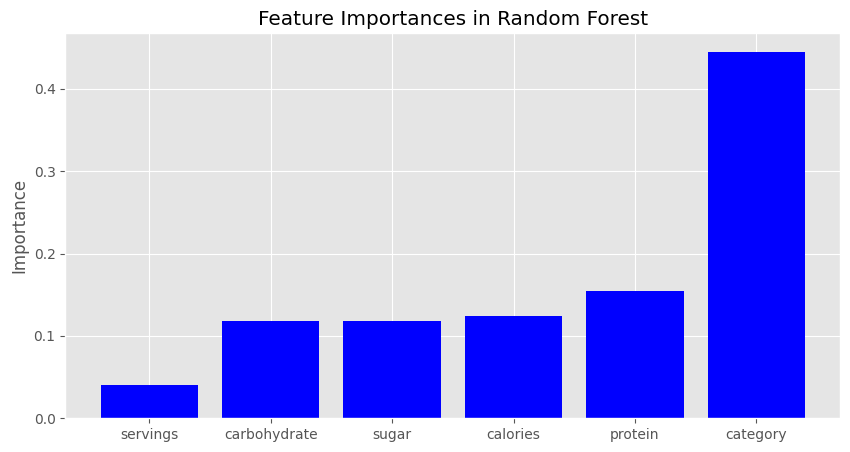

In [152]:
plt.figure(figsize=(10,5))
plt.title('Feature Importances in Random Forest')
plt.bar(range(len(rf_feature_importances)), rf_feature_importances['importance'], color='b', align='center')
plt.xticks(range(len(rf_feature_importances)), rf_feature_importances['features'])
plt.ylabel('Importance')
plt.show()

## 4. Model Evaluation

Now let's evaluate how well these 2 trained model is able to predict the values of the test dataset.

I am going to use 3 metrics to evaluate performance:

- **Accuracy**: the ratio of correctly predicted observations to the total observations
- **Precision**: the ability of the classifier to not label a negative sample as positive
- **Recall**: the ability of the classifier to find all the positive samples

In [153]:
y_test.value_counts()

1    173
0    112
Name: high_traffic, dtype: int64

### Logistic Regression Model

In [60]:
y_pred_logreg = logreg_best_model.predict(X_test)

In [62]:
tn_logreg, fp_logreg, fn_logreg, tp_logreg = confusion_matrix(y_test, y_pred_logreg).ravel()

Model Performance for Decision Tree Classifier Model

In [63]:
print(f"True positives: {tp_logreg}")
print(f"False positives: {fp_logreg}")
print(f"True negatives: {tn_logreg}")
print(f"False negatives: {fn_logreg}\n")

print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(f"Precision: {precision_score(y_test, y_pred_logreg)}")
print(f"Recall: {recall_score(y_test, y_pred_logreg)}")

True positives: 131
False positives: 28
True negatives: 84
False negatives: 42

Accuracy: 0.7543859649122807
Precision: 0.8238993710691824
Recall: 0.7572254335260116


### Random Forest Classifier Model

In [157]:
y_pred_rf = rf_best_model.predict(X_test)

In [158]:
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()

Model Performance for Random Forest Classifier Model

In [159]:
print(f"True positives: {tp_rf}")
print(f"False positives: {fp_rf}")
print(f"True negatives: {tn_rf}")
print(f"False negatives: {fn_rf}\n")

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")

True positives: 143
False positives: 45
True negatives: 67
False negatives: 30

Accuracy: 0.7368421052631579
Precision: 0.7606382978723404
Recall: 0.8265895953757225


### Results
**Accuracy:**
Model 1 (**Logistic Regression**) has a higher accuracy of approximately 75.43% compared to Model 2 (Random Forest), which has an accuracy of approximately 73.68%. Accuracy measures the overall correctness of predictions, and Model 1 is better in this aspect.

**Precision:**
Model 1 (**Logistic Regression**) has a higher precision of approximately 82.39% compared to Model 2 (Random Forest), which has a precision of approximately 76.06%. Precision measures the accuracy of positive predictions. Model 1 is better at correctly identifying high traffic recipes among the predicted positive cases.

**Recall:**
Model 2 (**Random Forest**) has a higher recall of approximately 82.66% compared to Model 1 (Logistic Regression), which has a recall of approximately 75.72%. Recall measures the ability of the model to correctly identify true positive cases (high traffic recipes) among all actual positive cases.


## 5. Business Metrics
There are 2 business goals:

- to predict which recipes will be with high traffic;
- to predict the "High" value of traffic of the recipes with 80% probability.

Model 1 (Logistic Regression) outperforms Model 2 (Random Forest) in terms of accuracy and precision, indicating that it is better at overall prediction accuracy and correctly identifying high traffic recipes among the predicted positive cases. Model 2 (Random Forest) has a higher recall, indicating that it is better at capturing more true positive cases (high traffic recipes) among all actual positive cases. It correctly identifies high traffic recipes at a rate of approximately 82.66%.

Both models seem to have performed relatively well, but they prioritize different aspects. Logistic Regression focuses on overall accuracy and precision, while Random Forest emphasizes capturing high traffic recipes effectively. **As correctly predicting high traffic recipes 80% of the time is business goal, Model 2 (Random Forest) might be preferred due to its higher recall, meaning it captures more high traffic recipes.**

## 6. Recommedations
We can plan to deploy this Random Forest Model into production. By implementing this model, **about 82.66% of high traffic recipes will be correctly identified**. This will help increase the subscription rate. I will recommend the following steps to ensure the model can be deployed and improved regularly.

- **Test Random Forest Model**: Implement the Random Forest model on new recipes and closely monitor its performance. Regularly evaluate its accuracy and fine-tune the model as needed to improve its effectiveness in predicting recipe popularity and high traffic outcomes.

- **Hyperparameter Tuning**: Continuously experiment with hyperparameter tuning for both models. Optimizing the models' hyperparameters can lead to better performance, enhanced recipe popularity predictions, and improved accuracy in identifying high traffic recipes.

- **Feature Engineering**: Explore and engineer new features that provide deeper insights into user behavior and preferences. Consider incorporating domain-specific features such as cuisine type, difficulty level, seasonal ingredients, and other relevant factors that may impact user engagement.

- **Data Collection and Personalization**: Gather more comprehensive data on user preferences, demographics, and interactions with recipes. This data will enable the creation of personalized strategies for notifying customers about recipes that align with their specific interests, thereby enhancing user engagement.

- **Iterative Improvement**: Continuously iterate on your models and strategies based on the feedback and results obtained from the site's performance. Be open to refining your approach to accommodate changing user preferences and trends.
 
By implementing these recommendations, you can create a more robust and user-centric recipe traffic site that caters to individual preferences, increases user satisfaction, and ultimately attracts more traffic. Remember to stay agile in your approach and leverage insights gained from data analysis to adapt your strategies for the best possible outcomes.
